<a href="https://colab.research.google.com/github/hoangtu1234/GenAI-ARmodel/blob/main/GenAI_ARmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 254 (delta 46), reused 32 (delta 32), pack-reused 182
Receiving objects: 100% (254/254), 94.70 MiB | 29.28 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Updating files: 100% (149/149), done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22738 sha256=cac61a84d090c3b8c0ef1225bdd2192dc0464131d7e1934f8288bf678aeeb7ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-9owbemn9/wheels/89/4d/b7/d666c1fdc2a51554c762f2cfe90dad1098871e7fea5c53eed4
Successfully built deepul


In [ ]:
from deepul.hw1_helper import *

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


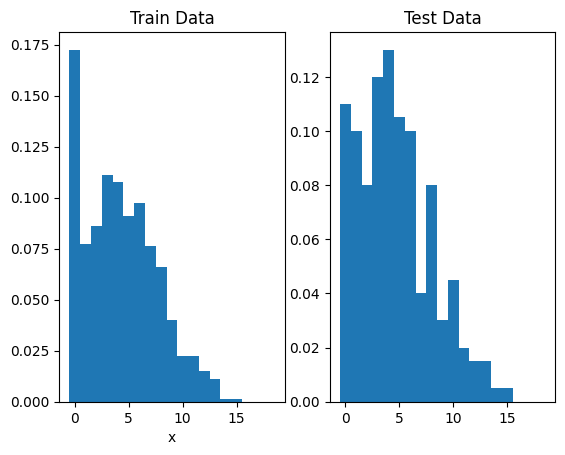

Dataset 2


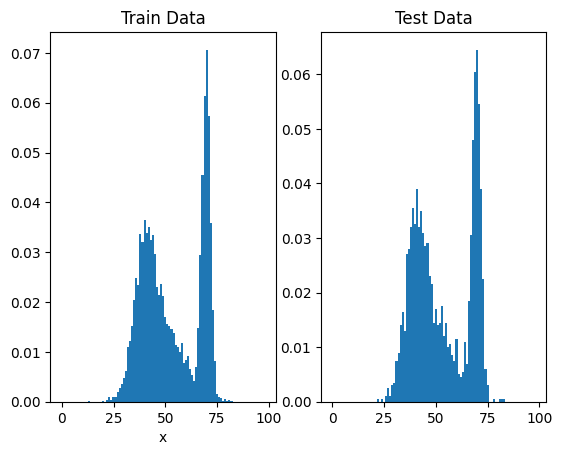

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{99}) \in \mathbb{R}^{100}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,99\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
quiet = True


def train(model, train_loader, optimizer, grad_clip = None):
  model.train()

  train_losses = []
  for x in train_loader:
    x = x.cuda().contiguous()
    loss = model.loss(x)
    optimizer.zero_grad()
    loss.backward()
    if grad_clip:
      torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses
def eval_loss(model, data_loader):
  model.eval()
  total_losses = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.cuda().contiguous()
      loss = model.loss(x)
      total_losses += loss * x.shape[0]
    avg_loss = total_losses / len(data_loader.dataset)
  return avg_loss.item()
def train_epoch(model, train_loader, test_loader, train_args):
  epochs, lr = train_args["epochs"], train_args["lr"]
  grad_clip = train_args.get("grad_clip", None)
  optimizer = optim.Adam(model.parameters(), lr = lr)

  train_loss = []
  test_loss = [eval_loss(model,test_loader)]
  for _ in range(epochs):
    model.train()
    train_loss.extend(train(model, train_loader,optimizer,grad_clip))
    test_loss.append(eval_loss(model, test_loader))
  return train_loss, test_loss

class Histogram1D(nn.Module):
  def __init__(self, d):
    super().__init__()
    self.d = d
    self.logits = nn.Parameter(torch.zeros(d), requires_grad=True)
  def loss(self, x):
    logit = self.logits.unsqueeze(0).repeat(x.shape[0],1)# size(x,d)
    return F.cross_entropy(logit, x.long())
  def get_dis(self):
    distribution = F.softmax(self.logits, dim=0)
    return distribution.detach().cpu().numpy()







In [ ]:
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """

  model = Histogram1D(d).cuda()
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epoch(model, train_loader, test_loader,
                                           dict(epochs=20, lr=1e-1))
  distribution = model.get_dis()

  return train_losses, test_losses, distribution

Final Test Loss: 2.5542


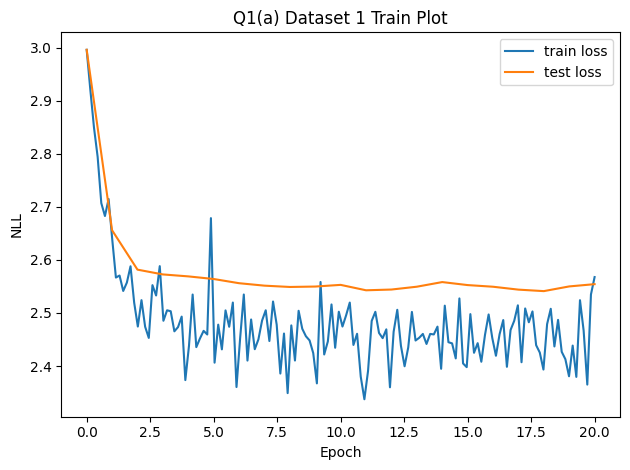

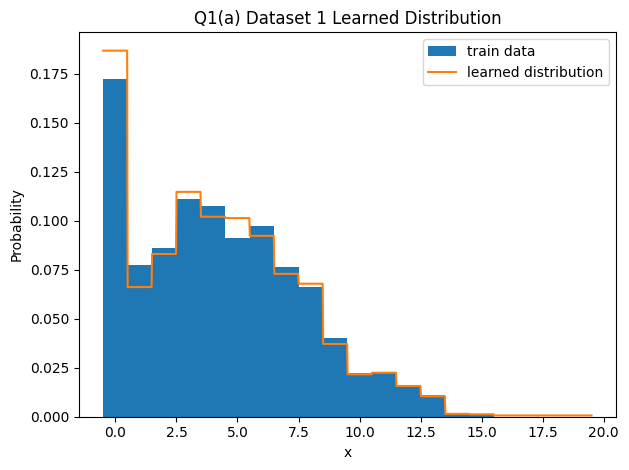

In [ ]:
q1_save_results(1, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class MixtureLogistic1D(nn.Module):
  def __init__(self, d, n_mix):
    super().__init__()
    self.d = d
    self.n_mix = n_mix
    self.logits = nn.Parameter(torch.zeros(n_mix), requires_grad = True)
    self.miu = nn.Parameter(torch.arange(n_mix).float()/(n_mix -1) * d, requires_grad = True)
    self.si = nn.Parameter(torch.randn(n_mix), requires_grad = True)

  def forward(self, x):
    d = self.d
    x = x.float().unsqueeze(1).repeat(1, self.n_mix)
    log_miu , log_si = self.miu.unsqueeze(0), self.si.unsqueeze(0)
    log_iv_si = torch.exp(-log_si)

    x_plus = log_iv_si * (x +0.5 - log_miu)
    x_subtract = log_iv_si * (x -0.5 - log_miu)

    sigmoid_x_plus = torch.sigmoid(x_plus)
    sigmoid_x_subtract = torch.sigmoid(x_subtract)

    log_delta_sigmoid = torch.log(torch.clamp((sigmoid_x_plus - sigmoid_x_subtract), min = 1e-12))


    log_x_0 = torch.log(torch.clamp(torch.sigmoid(log_iv_si * (0.5 - log_miu)), min = 1e-12))
    log_x_99 = torch.log(torch.clamp(1  -torch.sigmoid(log_iv_si * (d -1.5 -log_miu)), min = 1e-12))

    x_prob = torch.where(x < 1, log_x_0, torch.where(x > d - 2, log_x_99, log_delta_sigmoid))
    log_logits = F.log_softmax(self.logits, dim = 0).unsqueeze(0)

    x_prob += log_logits

    return torch.logsumexp(x_prob, dim =1)


  def loss(self, x):
    return -torch.mean(self(x))
  def get_distribution(self):
    with torch.no_grad():
      x = torch.FloatTensor(np.arange(self.d)).cuda()
      distribution = self(x).exp()
    return distribution.detach().cpu().numpy()




In [ ]:
class MixtureOfLogistics(nn.Module):
  def __init__(self, d, n_mix=4):
    super().__init__()
    self.d = d
    self.n_mix = n_mix

    self.logits = nn.Parameter(torch.zeros(n_mix), requires_grad=True)
    self.means = nn.Parameter(torch.arange(n_mix).float() / (n_mix - 1) * d,
                              requires_grad=True)
    self.log_scales = nn.Parameter(torch.randn(n_mix), requires_grad=True)

  def forward(self, x):
    d = self.d
    x = x.float().unsqueeze(1) # b x n_mix
    means, log_scales = self.means.unsqueeze(0), self.log_scales.unsqueeze(0) # 1 x n_mix
    inv_scales = torch.exp(-log_scales)

    plus_in = inv_scales * (x + 0.5 - means)
    min_in = inv_scales * (x - 0.5 - means)

    cdf_plus = torch.sigmoid(plus_in) # CDF of logistics at x + 0.5
    cdf_min = torch.sigmoid(min_in) # CDF of logistics at x - 0.5

     #cdf_delta = cdf_plus - cdf_min # probability of x in bin [x - 0.5, x + 0.5]
    log_cdf_delta = torch.log(torch.clamp(cdf_plus - cdf_min, min=1e-12))


    log_cdf_plus = torch.log(torch.clamp(torch.sigmoid(inv_scales * (0.5 - means)),
                                                       min=1e-12))
    log_cdf_min = torch.log(torch.clamp(1 - torch.sigmoid(inv_scales * (d - 1.5 - means)),
                                        min=1e-12))

    x_log_probs = torch.where(x < 0.001, log_cdf_plus,
                              torch.where(x > d - 1 - 1e-3,
                                          log_cdf_min, log_cdf_delta))
    pi_log_probs = F.log_softmax(self.logits, dim=0).unsqueeze(0)
    log_probs = x_log_probs + pi_log_probs
    return torch.logsumexp(log_probs, dim=1)

  def loss(self, x):
    return -torch.mean(self(x))

  def get_distribution(self):
    with torch.no_grad():
      x = torch.FloatTensor(np.arange(self.d)).cuda()
      distribution = self(x).exp()
    return distribution.detach().cpu().numpy()

In [ ]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """

  model = MixtureLogistic1D(d, n_mix=4).cuda()
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epoch(model, train_loader, test_loader,
                                           dict(epochs=10, lr=1e-1))
  distribution = model.get_distribution()

  return train_losses, test_losses, distribution

Final Test Loss: 2.5512


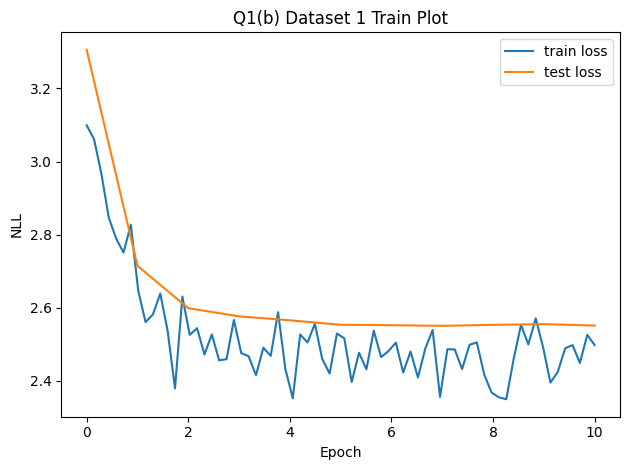

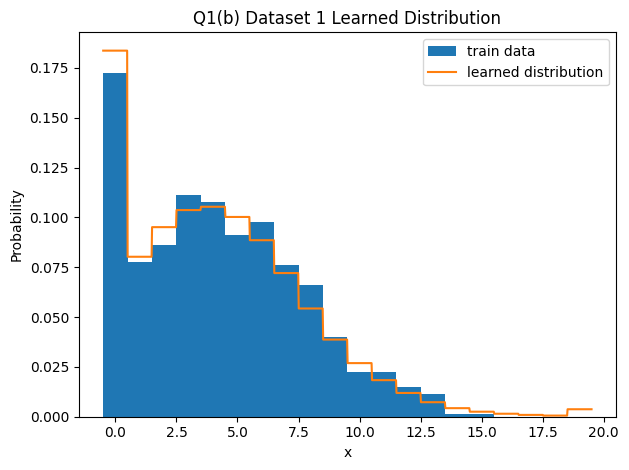

In [ ]:
q1_save_results(1, 'b', q1_b)

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

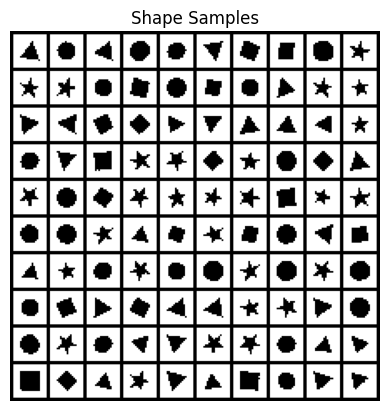

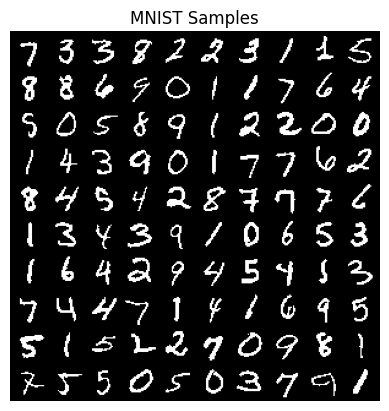

In [ ]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
def one_hot_encoder(labels, d):
  x = labels.shape[0]
  one_hot = torch.zeros(x,d).float().cuda()
  one_hot = torch.scatter_(1, labels.unsqueeze(1),1)
  return one_hot
class MaskedLinear(nn.Linear):
  def __init__(self, inputs, outputs, bias = True):
    super().__init__(inputs, outputs, bias)

    self.register_buffer('mask',torch.ones(outputs, inputs))
  def set_mask(self, mask):
    self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
  def forward(self, x):
    return F.linear(x,self.weight * self.mask, self.bias)
class MADE(nn.Module):
  #need : input shape :(tuple) size cua input
  #d : (int) range cua input value
  #hidden layer :([]) size cua tung layer an
  #odering : ([]) thu tu input
  #one_hot: (boolean) co dung onehot hay ko
  def __init__(self, input_shape, d, hidden_layer,ordering = None, onehot = False):
    super().__init__()
    self.input_shape = input_shape
    self.input_number = np.prod(input_shape)
    self.output_number = self.input_number * d
    self.d = d
    self.hidden_layer = hidden_layer
    self.ordering = np.arange(self.input_number) if ordering is None else ordering
    self.onehot = onehot

    #tao mask
    #first : tinh size cua moi hidden layer
    # size dau vao : neu dung onehot thi size = input_number *d
    # cac layer khac nhu hidden_layer va output_number
    self.neural_net = []
    layer_size = [self.input_number * d if onehot else self.input_number] + self.hidden_layer +[self.output_number]

    for l0, l1 in zip(layer_size, layer_size[1:]):
      self.neural_net.extend([
          MaskedLinear(l0, l1),
          nn.ReLU(),
      ])
    self.neural_net.pop()
    self.neural_net = nn.Sequential(*self.neural_net)

    self.mask ={}
    self.create_mask()
  def create_mask(self):
    L = len(self.hidden_layer)
    self.mask[-1] = self.ordering
    mask_l =[]

    for l in range(L):
      self.mask[l] = np.random.randint(self.mask[l-1].min(),self.input_number -1, size = self.hidden_layer[l])
      mask_indice_l = self.mask[l-1][:,None] <= self.mask[l][None,:]
      mask_l.append(mask_indice_l)

    mask_l.append(self.mask[L-1][:, None] <= self.mask[-1][None,:])
    mask_l[-1] = np.repeat(mask_l[-1], self.d, axis = 1)
    if self.onehot:
      mask_l[0]= np.repeat(mask_l[0], self.d, axis = 0)
    layers = [l for l in self.neural_net.modules() if  isinstance(l, MaskedLinear)]
    for l,m in zip(layers, mask_l):
      l.set_mask(m)
  def forward(self, x):
    batch_size = x.shape[0]
    if self.onehot:
      x = x.long().contiguous().view(-1)
      x = one_hot_encoder(x, self.d)
      x = x.view(batch_size, -1)
    else:
      x = x.float()
      x = x.view(batch_size, self.input_number)
    logits = self.neural_net(x).view(batch_size, self.input_number, self.d)
    return logits.permute(0, 2, 1).contiguous().view(batch_size, self.d, *self.input_shape)

  def loss(self, x):
      return F.cross_entropy(self(x), x.long())

  def sample(self, n):
    samples = torch.zeros(n, self.input_number).cuda()
    self.inv_ordering = {x: i for i, x in enumerate(self.ordering)}
    with torch.no_grad():
      for i in range(self.input_number):
        logits = self(samples).view(n, self.d, self.input_number)[:, :, self.inv_ordering[i]]
        probs = F.softmax(logits, dim=1)
        samples[:, self.inv_ordering[i]] = torch.multinomial(probs, 1).squeeze(-1)
      samples = samples.view(n, *self.input_shape)
    return samples.cpu().numpy()

  def get_distribution(self):
    assert self.input_shape == (2,), 'Only available for 2D joint'
    x = np.mgrid[0:self.d, 0:self.d].reshape(2, self.d ** 2).T
    x = torch.LongTensor(x).cuda()
    log_probs = F.log_softmax(self(x), dim=1)
    distribution = torch.gather(log_probs, 1, x.unsqueeze(1)).squeeze(1)
    distribution = distribution.sum(dim=1)
    return distribution.exp().view(self.d, self.d).detach().cpu().numpy()













In [ ]:
def q2_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """

  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  H, W = image_shape
  model = MADE((1, H, W), 2, hidden_layer=[512, 512]).cuda()
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epoch(model, train_loader, test_loader,
                                           dict(epochs=100, lr=1e-3))
  samples = model.sample(10)
  samples = np.transpose(samples, (0, 2, 3, 1))
  return train_losses, test_losses, samples

Final Test Loss: 0.0343


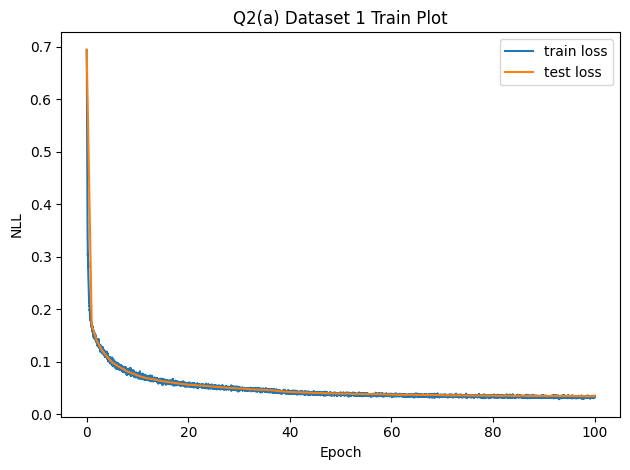

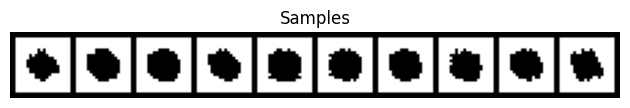

In [ ]:
q2a_save_results(1, q2_a)

Final Test Loss: 0.0868


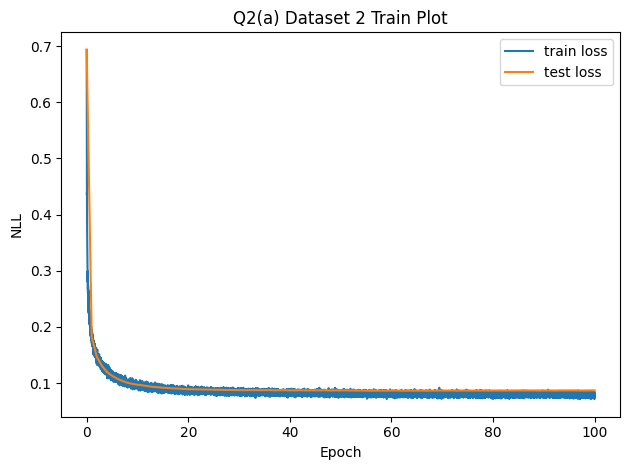

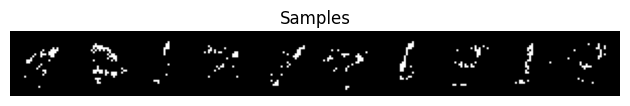

In [ ]:
q2a_save_results(2, q2_a)

# Question 3 PixelCNNs

Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.



## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network.

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

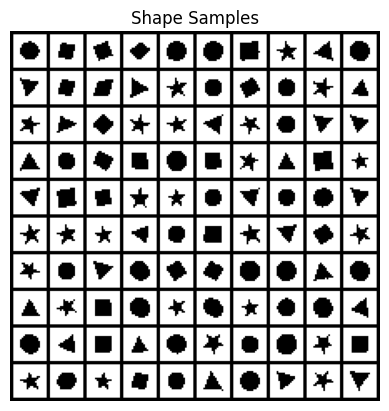

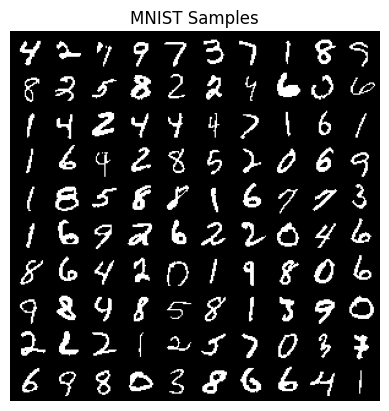

In [ ]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class MaskedConvo2D(nn.Conv2d):
  def __init__(self,mask_type, *args, color_conditioning = False, **kwargs):
    super().__init__(*args, **kwargs)
    self.color_conditioning = color_conditioning
    self.register_buffer("mask", torch.zeros_like(self.weight))
    self.create_mask(mask_type)

  def forward(self,x):
    batch_size = x.shape[0]
    out = F.conv2d(x, self.mask * self.weight, self.bias, self.stride,
                   self.padding,self.dilation, self.groups)
    return out


  def create_mask(self, mask_type):
    k = self.kernel_size[0]
    self.mask[:,:,:k//2] = 1
    self.mask[:,:,k//2,:k//2] =1

    one_third_in, one_third_out = self.in_channels//3, self.out_channels//3

    if self.color_conditioning:
      if mask_type =="B":
        self.mask[:one_third_out,:one_third_in,k//2,k//2] = 1
        self.mask[one_third_out:2*one_third_out,:2*one_third_in,k//2,k//2] =1
        self.mask[2*one_third_out:,:,k//2,k//2]=1
      else:
        self.mask[one_third_out:2*one_third_out,:one_third_in,k//2,k//2] =1
        self.mask[2*one_third_out:,:2*one_third_in,k//2,k//2]=1
    else:
      if mask_type=="B":
        self.mask[:,:,k//2,k//2]=1
class ResidualBlock(nn.Module):
  def __init__(self,in_channels, **kwargs):
    super().__init__()
    self.net = [
        nn.ReLU(),
        MaskedConvo2D('B', in_channels, in_channels // 2, 1, **kwargs),
        nn.ReLU(),
        MaskedConvo2D('B', in_channels // 2, in_channels // 2, 7, padding=3, **kwargs),
        nn.ReLU(),
        MaskedConvo2D('B', in_channels // 2, in_channels, 1, **kwargs)
    ]
    self.neural_net = nn.Sequential(*self.net)
  def forward(self,x):
    return self.neural_net(x) + x
class LayerNorm(nn.LayerNorm):
  def __init__(self,color_conditioning, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.color_conditioning = color_conditioning
  def forward(self,x):
    x = x.permute(0, 2, 3, 1).contiguous()
    x_shape = x.shape
    if self.color_conditioning:
      x = x.contiguous().view(*(x_shape[:-1] + (3, -1)))
    x = super().forward(x)
    if self.color_conditioning:
      x = x.view(*x_shape)
    return x.permute(0, 3, 1, 2).contiguous()

class PixelCNN(nn.Module):
  def __init__(self,input_shape, n_colors, n_filters = 64,
               kernel_size = 7, n_layers =5,
               use_resblock = False, color_conditioning = False):
    super().__init__()
    self.n_channels =  input_shape[0]
    kwargs = dict(color_conditioning = color_conditioning)
    if use_resblock:
      block_init = ResidualBlock(n_filters, **kwargs)
    else:
      block_init = MaskedConvo2D('B', n_filters, n_filters, kernel_size, padding = kernel_size //2, **kwargs)



    self.net = []
    self.net.append(MaskedConvo2D('A', self.n_channels, n_filters, kernel_size, padding = kernel_size //2, **kwargs))
    for _ in range(n_layers):
      if color_conditioning:
        self.net.append(LayerNorm(color_conditioning, (n_filters //3,)))
      else:
        self.net.append(LayerNorm(color_conditioning, (n_filters,)))

      self.net.extend([
          nn.ReLU(),
          block_init])
    self.net.extend([
        nn.ReLU(),
        MaskedConvo2D('B', n_filters, n_filters, 1, **kwargs)
    ])
    self.net.extend([
        nn.ReLU(),
        MaskedConvo2D('B', n_filters, self.n_channels * n_colors, 1, **kwargs)
    ])
    self.neural_net = nn.Sequential(*self.net)
    self.input_shape = input_shape
    self.n_colors = n_colors
    self.color_conditioning = color_conditioning
  def forward(self,x):
    batch_size = x.shape[0]
    x = x.float()
    logits = self.neural_net(x).contiguous()
    if self.color_conditioning:
      return logits.view(batch_size, self.n_channels, self.n_colors, *self.input_shape[1:]).permute(0, 2, 1, 3, 4)
    else:
      return logits.view(batch_size, self.n_colors, *self.input_shape)
  def loss(self, x):
    return F.cross_entropy(self(x), x.long())


  def sample(self, n):
    samples = torch.zeros(n, *self.input_shape).cuda()
    with torch.no_grad():
      for i in range(self.input_shape[1]):
        for j in range(self.input_shape[2]):
          for k in range(self.n_channels):
            logits = self(samples)[:,:,k,i,j]
            probs = F.softmax(logits, dim=1)
            samples[:,k,i,j] = torch.multinomial(probs, 1).squeeze(-1)
    return samples.permute(0, 2, 3, 1).cpu().numpy()












In [ ]:
def q2_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """

  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  H, W = image_shape
  model = PixelCNN((1, H, W), 2, n_layers=120, use_resblock=True).cuda()

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epoch(model, train_loader, test_loader,
                                           dict(epochs=10, lr=1e-3))
  samples = model.sample(100)
  return train_losses, test_losses, samples

Final Test Loss: 0.0445


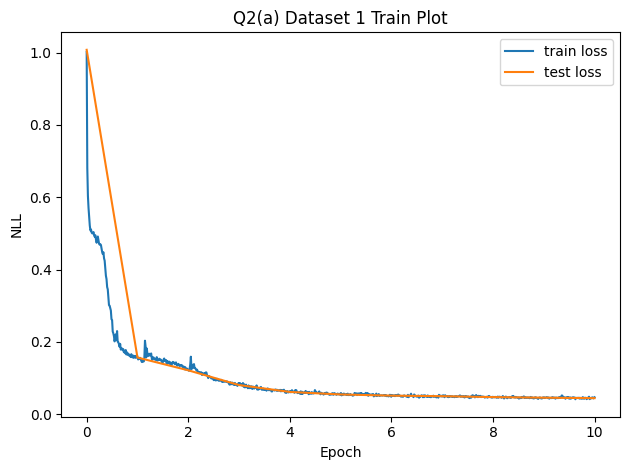

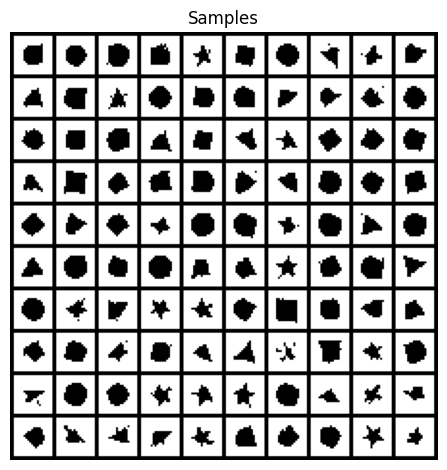

In [ ]:
q2a_save_results(1, q2_a)

<ipython-input-44-f1babe6f6eb6>:14: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  out = F.conv2d(x, self.mask * self.weight, self.bias, self.stride,


Final Test Loss: 0.0779


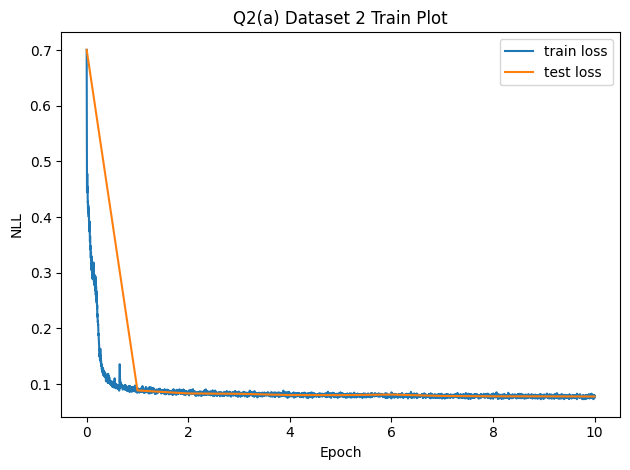

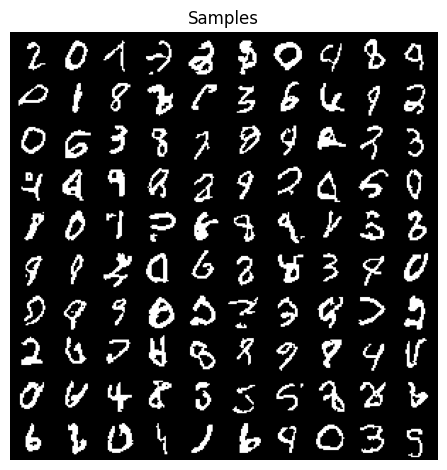

In [ ]:
q2a_save_results(2, q2_a)

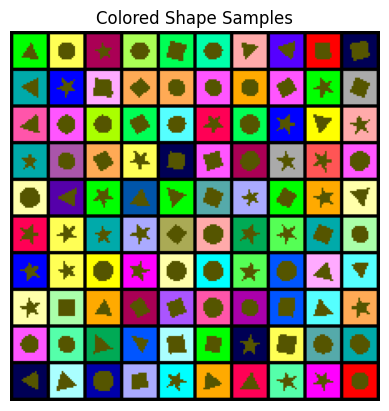

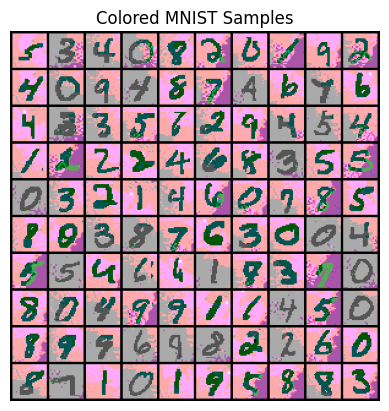

In [ ]:
visualize_q2b_data(1)
visualize_q2b_data(2)

In [ ]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
  """

  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  H, W, C = image_shape
  if dset_id == 1:
    model = PixelCNN((C, H, W), 4, n_filters=120, n_layers=8, use_resblock=True).cuda()
    train_args = dict(epochs=15, lr=1e-3, grad_clip=1)
  else:
    model = PixelCNN((C, H, W), 4, n_filters=120, n_layers=8, use_resblock=True).cuda()
    train_args=dict(epochs=15, lr=1e-3, grad_clip=1)

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epoch(model, train_loader, test_loader,
                                           train_args)
  samples = model.sample(100)
  return train_losses, test_losses, samples

<ipython-input-44-f1babe6f6eb6>:14: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  out = F.conv2d(x, self.mask * self.weight, self.bias, self.stride,


Final Test Loss: 0.0596


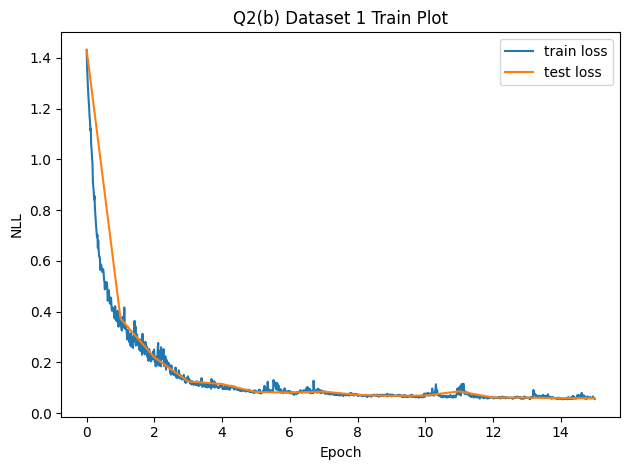

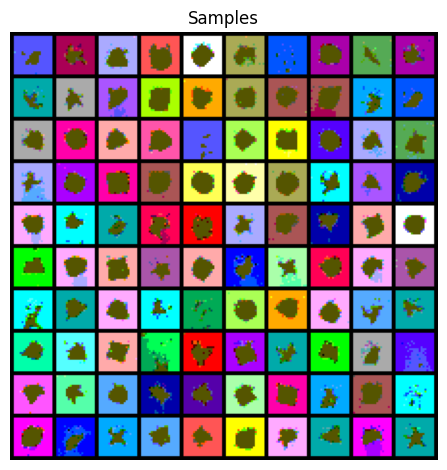

In [ ]:
q2b_save_results(1, 'b', q2_b)

<ipython-input-44-f1babe6f6eb6>:14: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  out = F.conv2d(x, self.mask * self.weight, self.bias, self.stride,


Final Test Loss: 0.0927


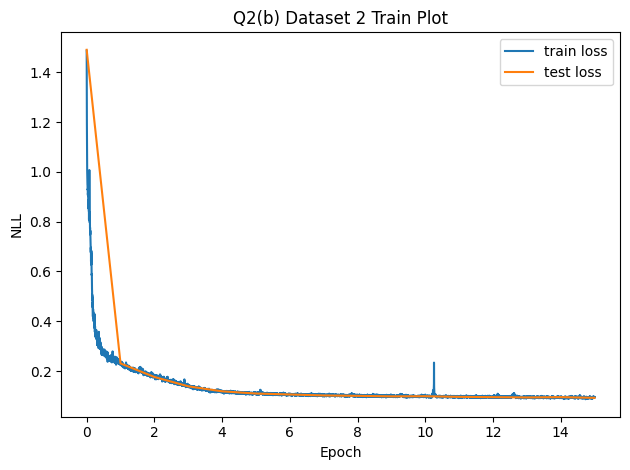

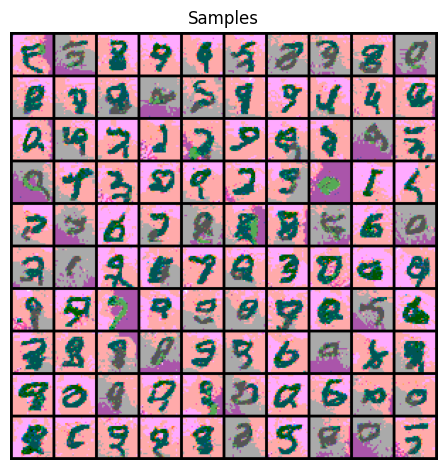

In [ ]:
q2b_save_results(2, 'b', q2_b)

In [ ]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
  """

  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  H, W, C = image_shape
  if dset_id == 1:
    model = PixelCNN((C, H, W), 4, n_filters=120, n_layers=8,
                     use_resblock=True, color_conditioning=True).cuda()
    train_args = dict(epochs=15, lr=1e-3, grad_clip=1)
  else:
    model = PixelCNN((C, H, W), 4, n_filters=120, n_layers=8,
                     use_resblock=True, color_conditioning=True).cuda()
    train_args=dict(epochs=15, lr=1e-3, grad_clip=1)

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epoch(model, train_loader, test_loader,
                                           train_args)
  samples = model.sample(100)
  return train_losses, test_losses, samples

<ipython-input-11-fa67dfe43f6f>:14: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  out = F.conv2d(x, self.mask * self.weight, self.bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Final Test Loss: 0.0293


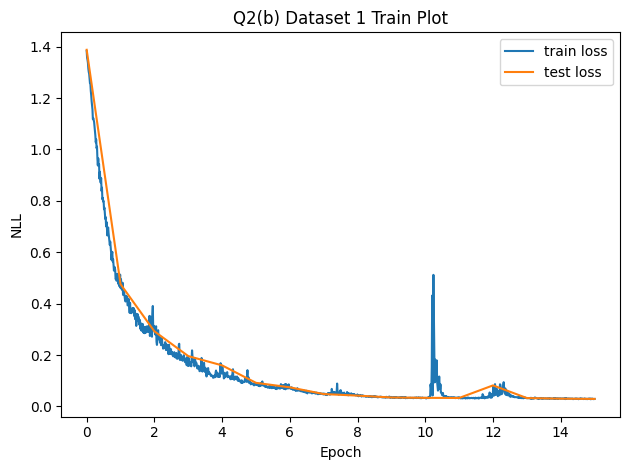

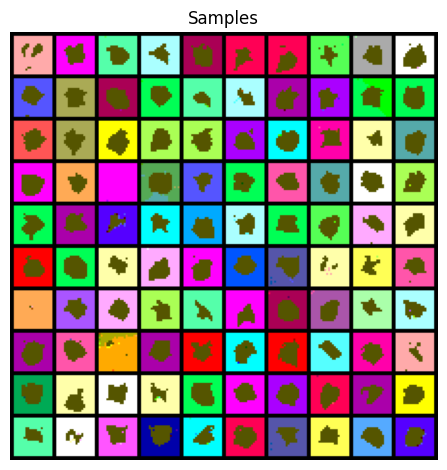

In [ ]:
q2b_save_results(1, 'b', q2_b)

<ipython-input-11-fa67dfe43f6f>:14: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  out = F.conv2d(x, self.mask * self.weight, self.bias, self.stride,


Final Test Loss: 0.0422


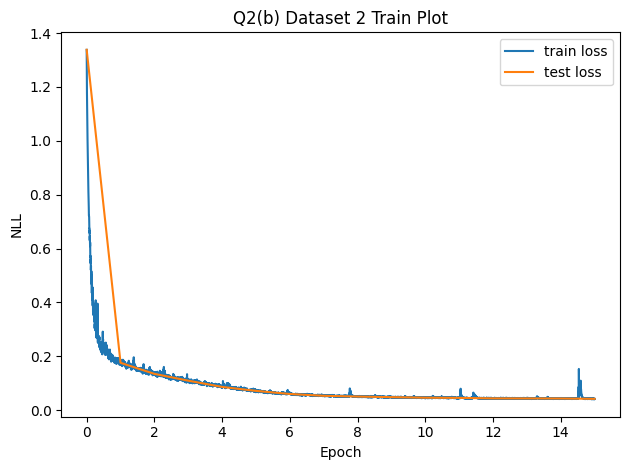

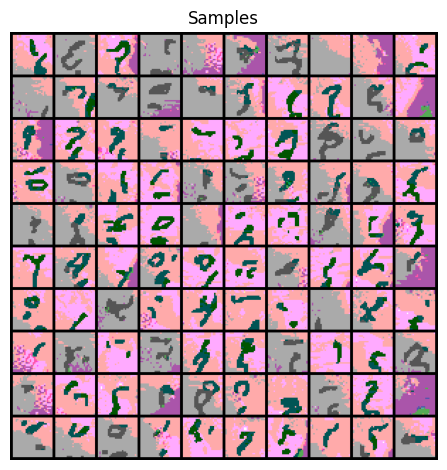

In [ ]:
q2b_save_results(2, 'b', q2_b)